In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
from keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt

#### Reading the data, normalizing and flattening it

##### Reading and Normalizing

In [2]:

train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 11385 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


##### Flattening

Preparing training tensors

In [3]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in train:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
train_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing validation tensors

In [4]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in val:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
val_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing testing tensors

In [5]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in test:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
test_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

#### 1 Hidden layer autoencoder

In [9]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training 1 Hidden Layer autoencoder with different number of neurons in bottleneck layer')
for num_neurons in [32, 64, 128, 256]:
    print(f'1 Hidden Layer : {num_neurons} neurons')
    # define model
    model = Sequential([
        layers.Dense(784, activation="relu", input_shape=(784,)),
        layers.Dense(num_neurons, activation="tanh", name="hidden", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(784, activation="relu", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    loss = tf.keras.losses.MeanSquaredError()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['mse'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
        TensorBoard(log_dir=f'./logdir/Q22/1_hidden_layer_{num_neurons}_neurons/')
    ]

    model_fit = model.fit(train_vectors[0].numpy(),train_vectors[0].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(val_vectors[0].numpy(), val_vectors[0].numpy()), shuffle=True, validation_batch_size=None)
    
    model_history[f'1_hidden_layer_{num_neurons}_neurons'] = model_fit.history['mse']
    
    hist_metric = 'mse'
    print(f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q22/1_hidden_layer_{num_neurons}_neurons.tf')



Training 1 Hidden Layer autoencoder with different number of neurons in bottleneck layer
1 Hidden Layer : 32 neurons
epochs: 627, mse: 0.011360627599060535

1 Hidden Layer : 64 neurons
epochs: 402, mse: 0.007456181570887566

1 Hidden Layer : 128 neurons
epochs: 237, mse: 0.006061496213078499

1 Hidden Layer : 256 neurons
epochs: 210, mse: 0.005021021235734224



In [17]:
for num_neurons in [32, 64, 128, 256]:
    print(f'1 Hidden Layer : {num_neurons} neurons')
    # define model
    model_path = f'models/Q22/1_hidden_layer_{num_neurons}_neurons.tf'
    model = tf.keras.models.load_model(model_path)
    
    model.evaluate(train_vectors[0].numpy(),train_vectors[0].numpy())
    model.evaluate(val_vectors[0].numpy(),val_vectors[0].numpy())    
    model.evaluate(test_vectors[0].numpy(),test_vectors[0].numpy())    

1 Hidden Layer : 32 neurons
119/119 [==============================] - 1s 6ms/step - loss: 0.0122 - mse: 0.0122
1 Hidden Layer : 64 neurons
119/119 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081
1 Hidden Layer : 128 neurons
119/119 [==============================] - 1s 6ms/step - loss: 0.0071 - mse: 0.0071
1 Hidden Layer : 256 neurons
119/119 [==============================] - 1s 7ms/step - loss: 0.0044 - mse: 0.0044


##### Displaying reconstructed image for training data

1/1 [==============================] - 0s 41ms/step


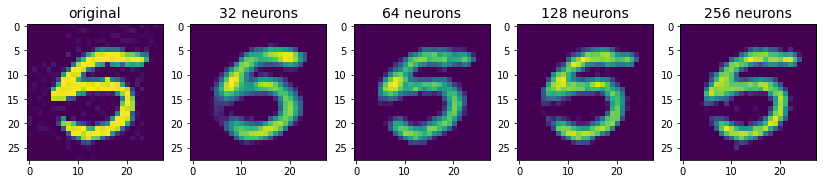

In [6]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 44ms/step


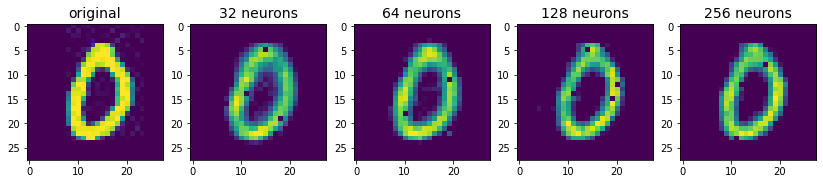

In [19]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 40ms/step


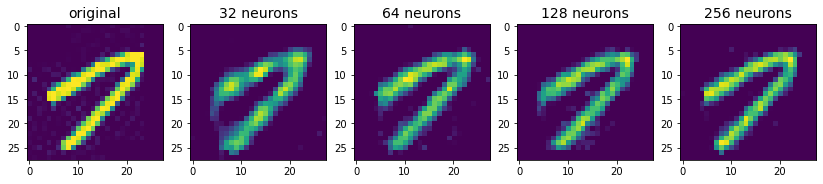

In [7]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[111].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[111].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 41ms/step


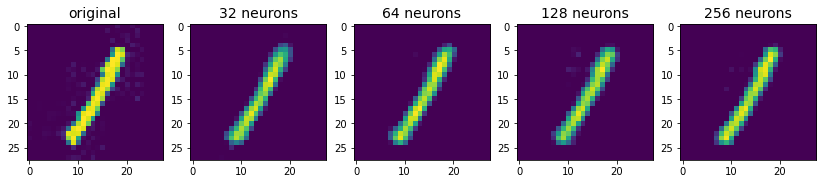

In [8]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[222].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[222].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 37ms/step


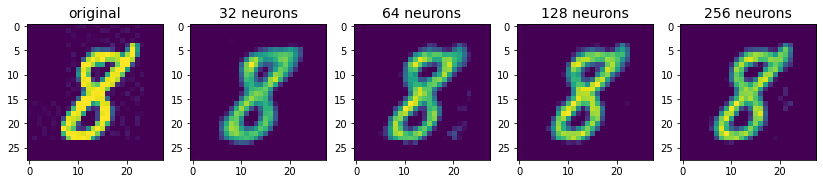

In [9]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[533].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[533].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

##### Displaying reconstructed images for validation data

1/1 [==============================] - 0s 38ms/step


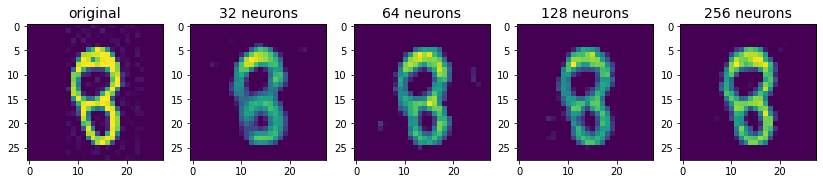

In [10]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 38ms/step


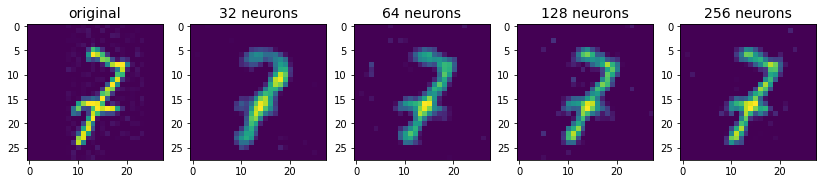

In [11]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 39ms/step


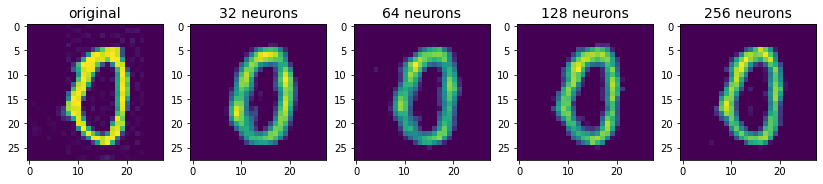

In [12]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[2].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[2].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 39ms/step


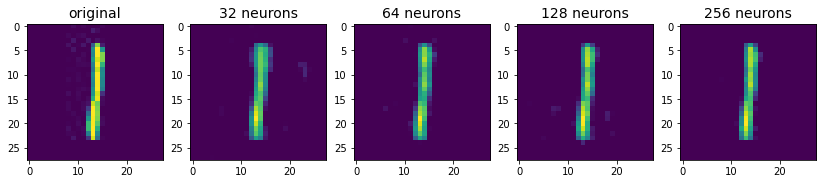

In [13]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[6].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[6].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 37ms/step


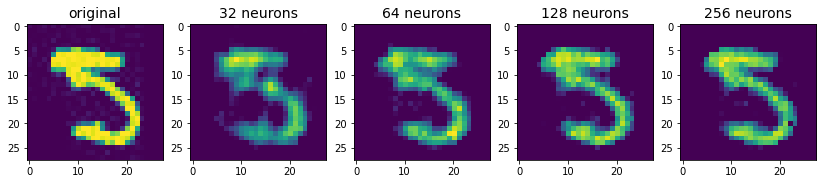

In [14]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[87].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[87].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

##### Displaying reconstructed images for testing data

1/1 [==============================] - 0s 39ms/step


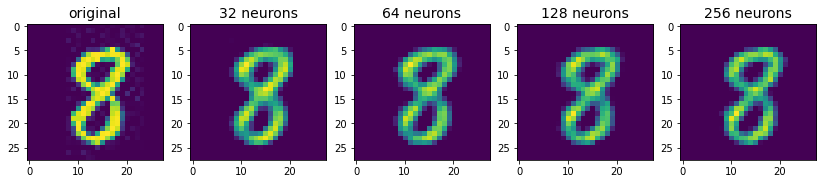

In [19]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 38ms/step


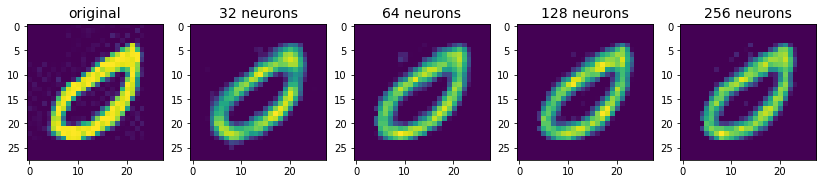

In [15]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[2].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[2].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 37ms/step


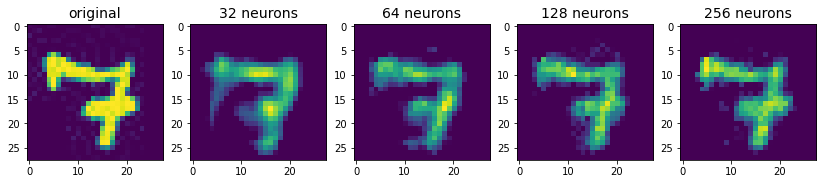

In [16]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 35ms/step


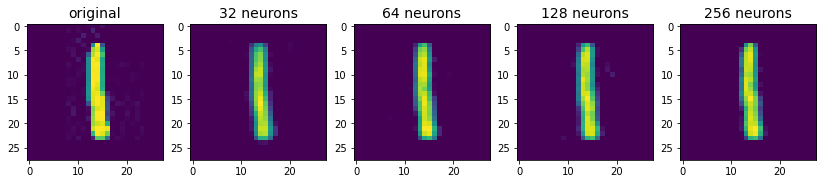

In [17]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[6].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[6].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 37ms/step


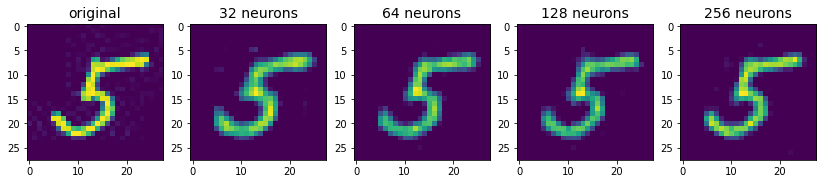

In [18]:
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[87].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'1_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='1') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[87].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

In [ ]:
# error train



#### 3 Hidden layer autoencoder

In [24]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer')
for num_neurons in [32, 64, 128, 256]:
    print(f'3 Hidden Layer : {num_neurons} neurons')
    # define model
    model = Sequential([
        layers.Dense(784, activation="relu", input_shape=(784,)),
        layers.Dense(400, activation="sigmoid", name="hidden1", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(num_neurons, activation="sigmoid", name="bottleneck", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(400, activation="sigmoid", name="hidden3", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(784, activation="relu", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    loss = tf.keras.losses.MeanSquaredError()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['mse'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
        TensorBoard(log_dir=f'./logdir/Q2/3_hidden_layer_{num_neurons}_neurons/')
    ]

    model_fit = model.fit(train_vectors[0].numpy(),train_vectors[0].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(val_vectors[0].numpy(), val_vectors[0].numpy()), shuffle=True, validation_batch_size=None)
    
    model_history[f'3_hidden_layer_{num_neurons}_neurons'] = model_fit.history['mse']
    
    hist_metric = 'mse'
    print(f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2/3_hidden_layer_{num_neurons}_neurons.tf')



Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer
3 Hidden Layer : 32 neurons
epochs: 231, mse: 0.061012152582407

3 Hidden Layer : 64 neurons
epochs: 220, mse: 0.05725286900997162

3 Hidden Layer : 128 neurons
epochs: 305, mse: 0.04583985358476639

3 Hidden Layer : 256 neurons
epochs: 193, mse: 0.04579508304595947



In [10]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer')
for num_neurons in [32, 64, 128, 256]:
    print(f'3 Hidden Layer : {num_neurons} neurons')
    # define model
    model = Sequential([
        layers.Dense(784, activation="relu", input_shape=(784,)),
        layers.Dense(400, activation="tanh", name="hidden1", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(num_neurons, activation="tanh", name="bottleneck", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(400, activation="tanh", name="hidden3", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(784, activation="relu", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    loss = tf.keras.losses.MeanSquaredError()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['mse'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
        TensorBoard(log_dir=f'./logdir/Q22/3_hidden_layer_{num_neurons}_neurons/')
    ]

    model_fit = model.fit(train_vectors[0].numpy(),train_vectors[0].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(val_vectors[0].numpy(), val_vectors[0].numpy()), shuffle=True, validation_batch_size=None)
    
    model_history[f'3_hidden_layer_{num_neurons}_neurons'] = model_fit.history['mse']
    
    hist_metric = 'mse'
    print(f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q22/3_hidden_layer_{num_neurons}_neurons.tf')

Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer
3 Hidden Layer : 32 neurons
epochs: 178, mse: 0.012226767838001251

3 Hidden Layer : 64 neurons
epochs: 351, mse: 0.005341471638530493

3 Hidden Layer : 128 neurons
epochs: 183, mse: 0.00601517828181386

3 Hidden Layer : 256 neurons
epochs: 259, mse: 0.004281977191567421



In [20]:
for num_neurons in [32, 64, 128, 256]:
    print(f'3 Hidden Layer : {num_neurons} neurons')
    # define model
    model_path = f'models/Q22/3_hidden_layer_{num_neurons}_neurons.tf'
    model = tf.keras.models.load_model(model_path)
    
    model.evaluate(train_vectors[0].numpy(),train_vectors[0].numpy())
    model.evaluate(val_vectors[0].numpy(),val_vectors[0].numpy())    
    model.evaluate(test_vectors[0].numpy(),test_vectors[0].numpy())  

3 Hidden Layer : 32 neurons
119/119 [==============================] - 1s 8ms/step - loss: 0.0126 - mse: 0.0126
3 Hidden Layer : 64 neurons
119/119 [==============================] - 1s 6ms/step - loss: 0.0062 - mse: 0.0062
3 Hidden Layer : 128 neurons
119/119 [==============================] - 1s 11ms/step - loss: 0.0065 - mse: 0.0065
3 Hidden Layer : 256 neurons
119/119 [==============================] - 1s 12ms/step - loss: 0.0046 - mse: 0.0046


##### Displaying reconstructed image for training data

1/1 [==============================] - 0s 196ms/step


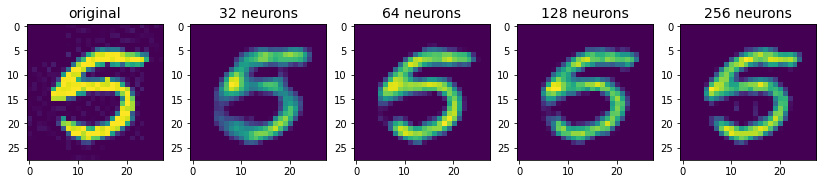

In [20]:
# 0 1 111 222 533
ct = 1 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


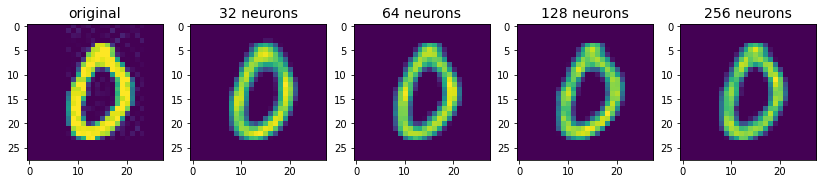

In [21]:
# 0 1 111 222 533
ct = 1 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 46ms/step


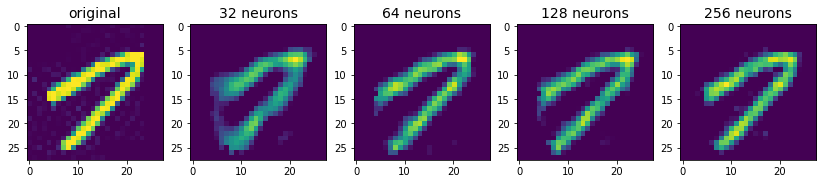

In [22]:
# 0 1 111 222 533
ct = 1 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[111].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[111].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 46ms/step


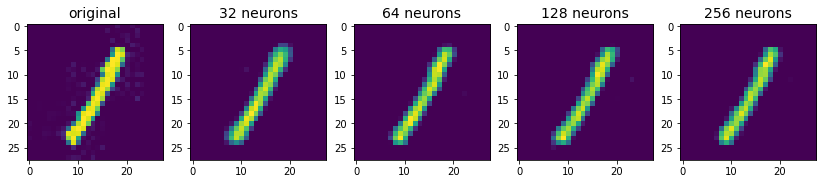

In [23]:
# 0 1 111 222 533
ct = 1 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[222].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[222].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 67ms/step


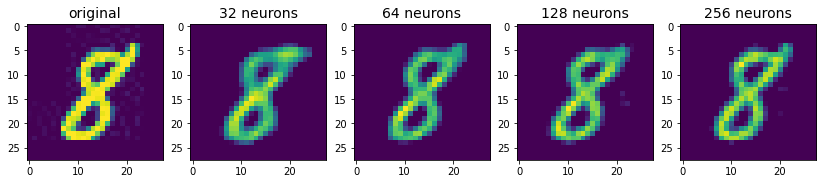

In [24]:
# 0 1 111 222 533
ct = 1 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(train_vectors[0].numpy()[533].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[533].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

##### Displaying reconstructed image for validation data

1/1 [==============================] - 0s 46ms/step


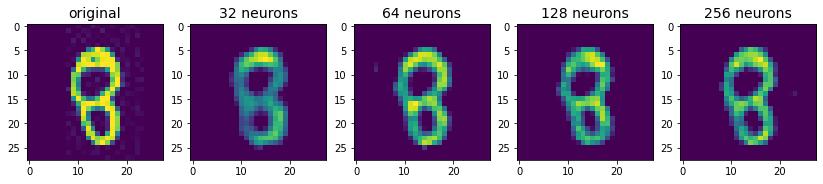

In [25]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


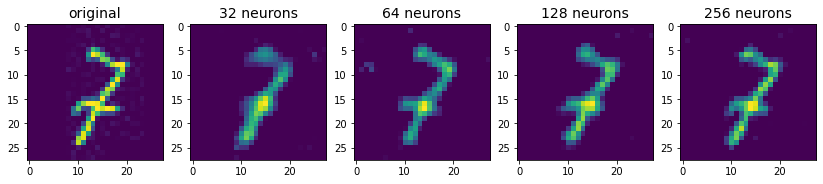

In [26]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


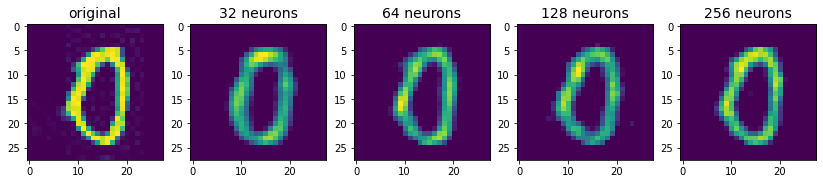

In [27]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[2].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[2].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


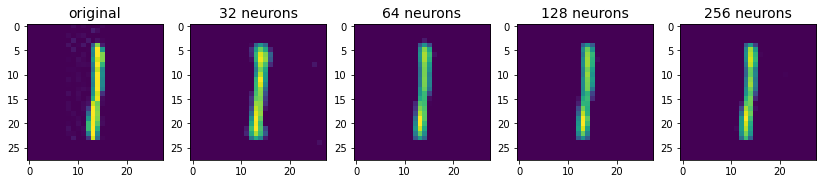

In [28]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[6].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[6].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 52ms/step


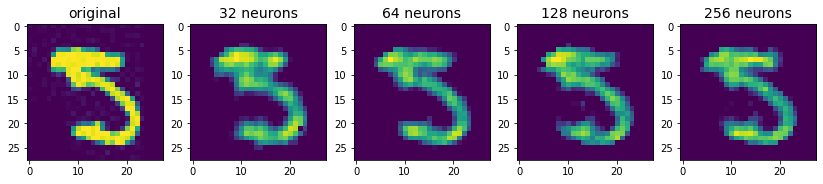

In [29]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(val_vectors[0].numpy()[87].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[87].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

##### Displaying reconstructed image for testing data

1/1 [==============================] - 0s 46ms/step


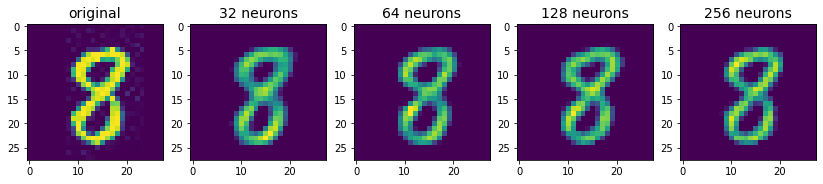

In [30]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[0].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


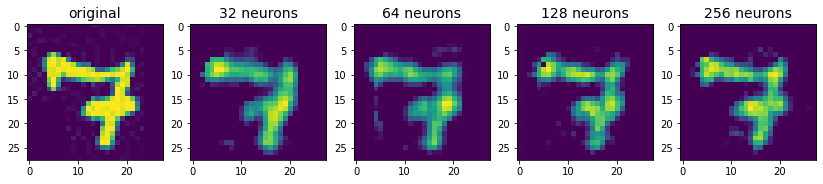

In [31]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[1].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[1].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 45ms/step


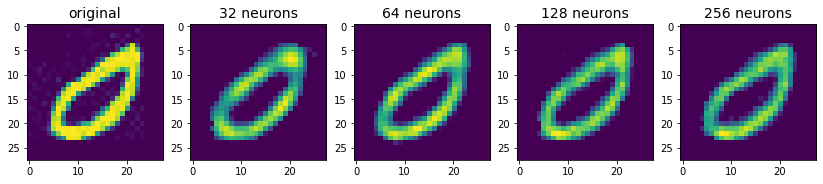

In [32]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[2].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[2].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 46ms/step


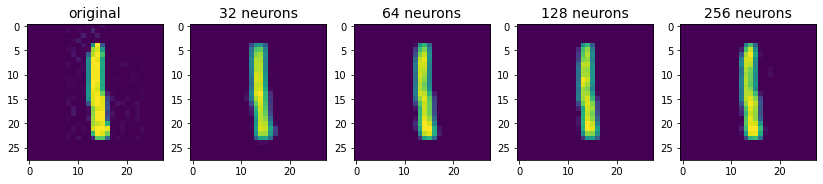

In [33]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[6].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[6].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()

1/1 [==============================] - 0s 46ms/step


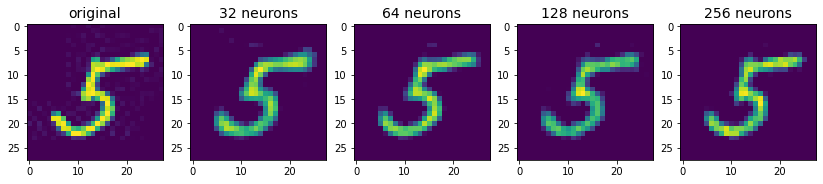

In [34]:
# 0 1 2 6 87
ct = 1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 7, ct)
ax.imshow(test_vectors[0].numpy()[87].reshape(28,28))
ax.set_title(f'original', fontdict = {'fontsize':14}, )
ct+=1

hneuron = [32, 64, 128, 256]
for n in hneuron:
    # models = os.listdir('./models/Q1')
    model = f'3_hidden_layer_{n}_neurons.tf'
    model_path = os.path.join('./models/Q22', model)
    if(model[0]!='3') : break
    # print(model)
    
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[87].reshape(1,784))
    
    ax = fig.add_subplot(1, 7, ct)
    ax.imshow(predictions.reshape(28,28))
    ax.set_title(f'{n} neurons', fontdict = {'fontsize':14}, )
    ct+=1

plt.show()